In [1]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

2023-08-16 15:12:10.190785: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 15:12:10.219540: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 15:12:10.221589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 15:12:10.807956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [3]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [4]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [5]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
hist = autoencoder.fit(x_train, x_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(x_test, x_test))

Epoch 1/50


2023-08-16 15:12:11.878264: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-08-16 15:12:11.973553: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


235/235 [==============================] - 2s 5ms/step - loss: 0.2736 - val_loss: 0.1911
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1724 - val_loss: 0.1554
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1462 - val_loss: 0.1356
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1302 - val_loss: 0.1228
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1195 - val_loss: 0.1141
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1118 - val_loss: 0.1076
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.1064 - val_loss: 0.1030
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1026 - val_loss: 0.0997
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0998 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.0978 - val_loss: 0.0959
Epoch 11/5

In [9]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 771us/step


In [10]:
x_test.shape

(10000, 784)

In [11]:
encoded_imgs.shape

(10000, 32)

In [12]:
decoded_imgs.shape

(10000, 784)

In [13]:
np.ceil(10_000/313)

32.0

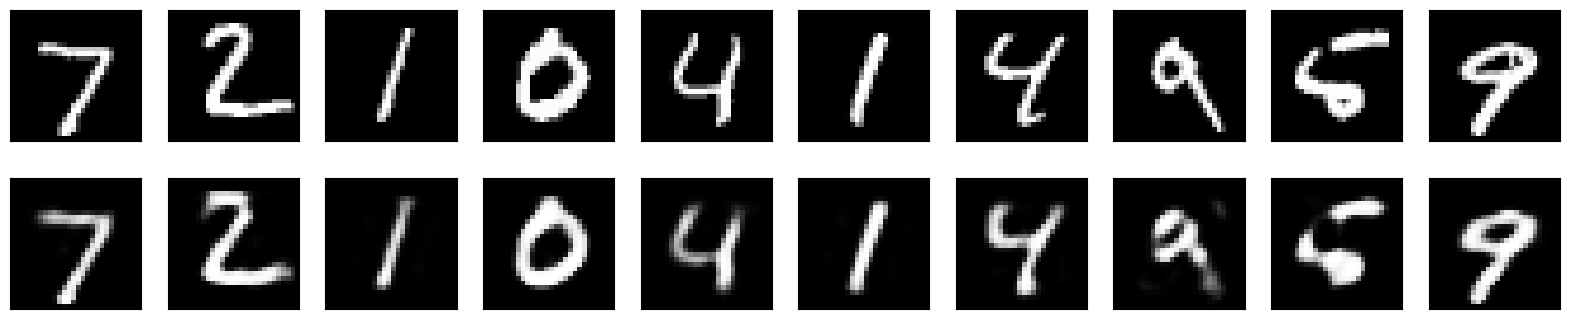

In [14]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
from sklearn import linear_model

In [16]:
lr = linear_model.LogisticRegression()

In [28]:
lr.fit(encoder.predict(x_train[:1000]), np.mod(y_train[:1000], 2)) # odd or even

32/32 [==============================] - 0s 1ms/step


LogisticRegression()

In [29]:
from sklearn import metrics

In [30]:
lr.score(encoded_imgs, np.mod(y_test, 2))

0.863

In [22]:
lr2 = linear_model.LogisticRegression()

In [23]:
lr2.fit(x_train, np.mod(y_train, 2)) # odd or even

/home/oren/projects/humans_thoughts/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
lr2.score(x_test, np.mod(y_test, 2))

0.9011

In [25]:
lr2.fit(x_train[:1000], np.mod(y_train[:1000], 2)) # odd or even

/home/oren/projects/humans_thoughts/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
lr2.score(x_test, np.mod(y_test, 2))

0.8594

In [33]:
import pandas as pd

pd.Series(y_train[:1000]).value_counts()

7    117
1    116
4    105
9    100
2     99
0     97
6     94
3     93
5     92
8     87
Name: count, dtype: int64

- If learning on all training samples, gets a better accuracy with the original pixel values. If learning on 1000 training images, gets better results with the embeddings (that were derived from the whole dataset).